In [91]:
import math
import matplotlib.pyplot as plt
import matplotlib.lines as mpl_lines
import numpy as np

%matplotlib widget

# code modified to change negative values to positive ones
def lmap(f,x):
    return list(map(f,x))

# code modified to change negative values to positive ones
def lfilter(f,x):
    return list(filter(f,x))

def loadResultsCSV(path):
    def _f(x):
        if(x == "True"):
            return True
        elif (x=="False"):
            return False
        else:
            return float(x)
        
    with open(path) as inp:
        lines = inp.read().split("\n")[1:-2]
        rows = lmap(
            lambda l: 
                lmap(
                _f, 
                l.strip().split(",")
            ), 
            lines
        )

        return ({
            "length": lines.__len__(),
            "d": lmap(lambda r: r[0], rows), 
            "o": lmap(lambda r: r[1], rows),
            "k": lmap(lambda r: r[2], rows),
            "avg": lmap(lambda r: r[3], rows),
            "dev": lmap(lambda r: r[4], rows),
            "switch": lmap(lambda r: r[5], rows),
            "der_avg": lmap(lambda r: r[6], rows)
        }, lines.__len__())

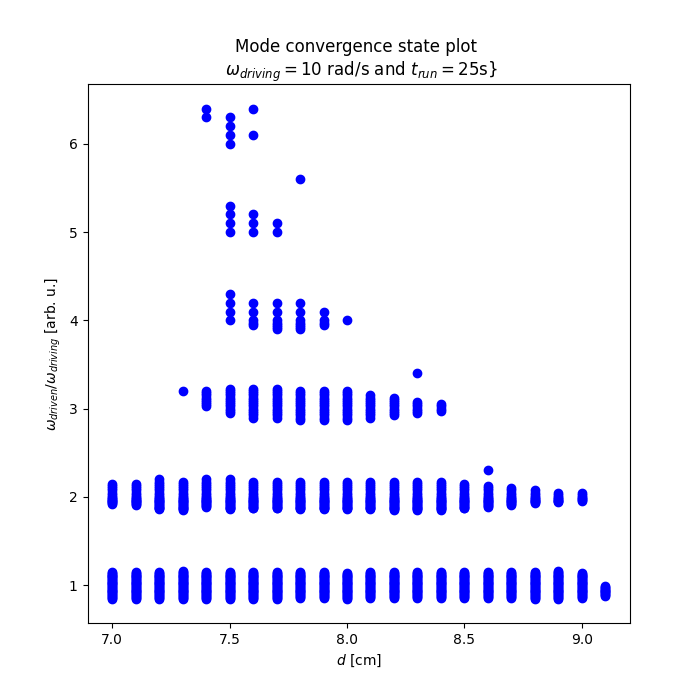

In [92]:
(data, _len) = loadResultsCSV("./results.csv")

plt.figure(figsize=(7,7))
plt.xlabel("$d$ [cm]")
plt.ylabel("$\omega_{driven} / \omega_{driving}$ [arb. u.]")
plt.title("Mode convergence state plot \n $\omega_{driving} = 10$ rad/s and $t_{run} = 25$s}")

max_offset = 0.2
max_avg_dev = 0.1

for i in range(_len):
    # if not data["switch"][i]:
    #     # the spinner did not change direction
    #     plt.scatter(
    #         data["d"][i],
    #         data["k"][i],
    #         marker=",",
    #         color="b"
    #     )
    # else:
    #     plt.scatter(
    #         data["d"][i],
    #         data["k"][i],
    #         marker=",",
    #         color="r"
    #     )

    if not data["switch"][i]:
        # the spinner did not change direction
        if data["dev"][i] < max_avg_dev:
            if abs(data["avg"][i] - round(data["avg"][i])) < max_offset:
                plt.scatter(
                    data["d"][i],
                    data["k"][i],
                    marker="o",
                    color="b"
                )